In [55]:
# Import modules
import os
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

In [3]:
# DOWNLOADING THE DATASET: UNCOMMENT BELOW:
# !wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
# !wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet
# Or ELse download from here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment") # create this experiment if there is no experiment with this name


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [5]:
# Reading the dataset:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet') 
df.head()                                               # Inspection

# Note you have to install pyarrow. To do so, uncomment below
#!pip install pyarrow


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [6]:
# shape of dataframe
df.shape

(76518, 20)

In [7]:
# Processing the Dataset:
df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
df["duration"] = df["duration"].apply(lambda x: x.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <=60)]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [8]:
# shape of dataframe after processing
df.shape

(73908, 21)

In [9]:
# DataFrame Inspection:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [10]:
# Processing the dataset:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str) # conversion
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [11]:
# Initializing one hot encoding:
train_dicts = df[categorical + numerical].to_dict(orient="records") # initialize dict
dict_v = DictVectorizer()
X_train = dict_v.fit_transform(train_dicts)
y_train = df["duration"].values

In [12]:
# Training Linear Regression
lr = LinearRegression()                                        # Intialization
lr.fit(X_train, y_train)                                       # Training model
y_pred = lr.predict(X_train)                                   # Initializing prediction
mse_error = mean_squared_error(y_train, y_pred, squared=False) # calculating mse
print(mse_error)

9.775439682517721


Not so bad. Model prediction shows that on average it is late ny 9 minutes.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


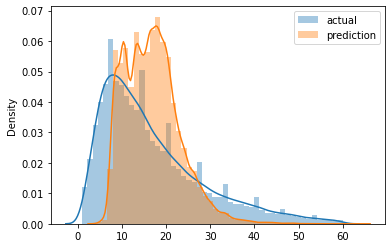

In [13]:
# Visualization of prediction
sns.distplot(y_train, label="actual")
sns.distplot(y_pred, label="prediction")
plt.legend()

Prediction is slightly mismatched from actual but it follows similar pattern of train data.

## Put everything on preparing dataframe in a function

In [14]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df["lpep_dropoff_datetime"] =  pd.to_datetime(df["lpep_dropoff_datetime"])
        df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)
    else:
        print("Only .csv | parquet files are allowed")
        return
    df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df["duration"] = df.duration.apply(lambda x: x.total_seconds() / 60)    # convert into minutes
    df = df[(df.duration >=1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    return df

In [15]:
# Initalizing train and validation DataFrame:
df_train = read_dataframe("./data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("./data/green_tripdata_2021-02.parquet")
print(df_train.shape)
print(df_val.shape)

(73908, 21)
(61921, 21)


In [16]:
# Processing the data:
df_train["PU_DO"] = df_train["PULocationID"] + '_' + df_train['DOLocationID']
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667,75_75


In [17]:
# Initialize one hot encoding in a function:
def one_hot_encoding(df_train, df_val, categorical, numerical):
    '''
    categorical: List of categorical col names
    numerical: List of numerical col names
    '''
    dict_v = DictVectorizer()
    train_dicts = df_train[categorical + numerical].to_dict(orient="records") # initialize dict
    X_train = dict_v.fit_transform(train_dicts)
    val_dicts = df_val[categorical + numerical].to_dict(orient="records")
    X_val = dict_v.transform(val_dicts)
    target = "duration"
    y_train = df_train[target].values
    y_val = df_val[target].values
    return dict_v, X_train, X_val, y_train, y_val

In [18]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]
dv, X_train, X_val, y_train, y_val = one_hot_encoding(df_train, df_val, categorical, numerical)

In [19]:
# Training Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print(mean_squared_error(y_val, y_pred, squared=False)) # print RMSE

7.479582908966909


In [20]:
# Save the train model
if not os.path.isdir("models"):
    os.makedirs("./models")
with open("models/lin_reg.bin", "wb") as f:
    pickle.dump((dv, lr), f)

In [21]:
# Training Lasso Regression
# Tracking with mlflow
with mlflow.start_run():
    mlflow.set_tag("developer", "Sushant")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False) # Print RMSE
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin",
                       artifact_path="models_pickle")
    

In [22]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
# PREPARING THE XGBOOST DATASET:
train = xgb.DMatrix(X_train, label=y_train) # Train Dataset
valid = xgb.DMatrix(X_val, label=y_val)     # Test Dataset

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")  # Tracking model
        mlflow.log_params(params)           # Tracking parameters
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid) # Generating predictions.
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse) # Tracking metric.
    
    return {"loss":rmse, "status": STATUS_OK}

In [26]:
# INITIALIZING SEARCH SPACE:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": 'reg:linear',
    "seed": 22
}

# TRAINING AND OPTIMIZING XGBOOST:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()
)

[17:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:20.20834                                                                                           
[1]	validation-rmse:19.28304                                                                                           
[2]	validation-rmse:18.41364                                                                                           
[3]	validation-rmse:17.59818                                                                                           
[4]	validation-rmse:16.83309                                                                                           
[5]	validation-rmse:16.11488                                                                                           
[6]	validation-rmse:15.44219                                                                           

[66]	validation-rmse:6.65540                                                                                           
[67]	validation-rmse:6.64810                                                                                           
[68]	validation-rmse:6.64128                                                                                           
[69]	validation-rmse:6.63497                                                                                           
[70]	validation-rmse:6.62918                                                                                           
[71]	validation-rmse:6.62364                                                                                           
[72]	validation-rmse:6.61823                                                                                           
[73]	validation-rmse:6.61297                                                                                           
[74]	validation-rmse:6.60812            

[134]	validation-rmse:6.51519                                                                                          
[135]	validation-rmse:6.51481                                                                                          
[136]	validation-rmse:6.51438                                                                                          
[137]	validation-rmse:6.51402                                                                                          
[138]	validation-rmse:6.51344                                                                                          
[139]	validation-rmse:6.51315                                                                                          
[140]	validation-rmse:6.51262                                                                                          
[141]	validation-rmse:6.51207                                                                                          
[142]	validation-rmse:6.51155           

[202]	validation-rmse:6.49535                                                                                          
[203]	validation-rmse:6.49515                                                                                          
[204]	validation-rmse:6.49491                                                                                          
[205]	validation-rmse:6.49452                                                                                          
[206]	validation-rmse:6.49436                                                                                          
[207]	validation-rmse:6.49411                                                                                          
[208]	validation-rmse:6.49390                                                                                          
[209]	validation-rmse:6.49368                                                                                          
[210]	validation-rmse:6.49354           

[270]	validation-rmse:6.48433                                                                                          
[271]	validation-rmse:6.48418                                                                                          
[272]	validation-rmse:6.48401                                                                                          
[273]	validation-rmse:6.48386                                                                                          
[274]	validation-rmse:6.48375                                                                                          
[275]	validation-rmse:6.48341                                                                                          
[276]	validation-rmse:6.48329                                                                                          
[277]	validation-rmse:6.48310                                                                                          
[278]	validation-rmse:6.48296           

[338]	validation-rmse:6.47591                                                                                          
[339]	validation-rmse:6.47592                                                                                          
[340]	validation-rmse:6.47583                                                                                          
[341]	validation-rmse:6.47578                                                                                          
[342]	validation-rmse:6.47575                                                                                          
[343]	validation-rmse:6.47565                                                                                          
[344]	validation-rmse:6.47554                                                                                          
[345]	validation-rmse:6.47539                                                                                          
[346]	validation-rmse:6.47531           

[406]	validation-rmse:6.46915                                                                                          
[407]	validation-rmse:6.46910                                                                                          
[408]	validation-rmse:6.46890                                                                                          
[409]	validation-rmse:6.46883                                                                                          
[410]	validation-rmse:6.46862                                                                                          
[411]	validation-rmse:6.46843                                                                                          
[412]	validation-rmse:6.46839                                                                                          
[413]	validation-rmse:6.46837                                                                                          
[414]	validation-rmse:6.46838           

[474]	validation-rmse:6.46303                                                                                          
[475]	validation-rmse:6.46289                                                                                          
[476]	validation-rmse:6.46287                                                                                          
[477]	validation-rmse:6.46286                                                                                          
[478]	validation-rmse:6.46285                                                                                          
[479]	validation-rmse:6.46279                                                                                          
[480]	validation-rmse:6.46277                                                                                          
[481]	validation-rmse:6.46275                                                                                          
[482]	validation-rmse:6.46264           

[542]	validation-rmse:6.45819                                                                                          
[543]	validation-rmse:6.45808                                                                                          
[544]	validation-rmse:6.45805                                                                                          
[545]	validation-rmse:6.45796                                                                                          
[546]	validation-rmse:6.45783                                                                                          
[547]	validation-rmse:6.45778                                                                                          
[548]	validation-rmse:6.45770                                                                                          
[549]	validation-rmse:6.45774                                                                                          
[550]	validation-rmse:6.45760           

[610]	validation-rmse:6.45477                                                                                          
[611]	validation-rmse:6.45466                                                                                          
[612]	validation-rmse:6.45466                                                                                          
[613]	validation-rmse:6.45460                                                                                          
[614]	validation-rmse:6.45470                                                                                          
[615]	validation-rmse:6.45470                                                                                          
[616]	validation-rmse:6.45474                                                                                          
[617]	validation-rmse:6.45467                                                                                          
[618]	validation-rmse:6.45466           

[678]	validation-rmse:6.45195                                                                                          
[679]	validation-rmse:6.45189                                                                                          
[680]	validation-rmse:6.45182                                                                                          
[681]	validation-rmse:6.45183                                                                                          
[682]	validation-rmse:6.45175                                                                                          
[683]	validation-rmse:6.45174                                                                                          
[684]	validation-rmse:6.45167                                                                                          
[685]	validation-rmse:6.45167                                                                                          
[686]	validation-rmse:6.45166           

[746]	validation-rmse:6.44857                                                                                          
[747]	validation-rmse:6.44853                                                                                          
[748]	validation-rmse:6.44850                                                                                          
[749]	validation-rmse:6.44849                                                                                          
[750]	validation-rmse:6.44846                                                                                          
[751]	validation-rmse:6.44838                                                                                          
[752]	validation-rmse:6.44833                                                                                          
[753]	validation-rmse:6.44831                                                                                          
[754]	validation-rmse:6.44830           

[814]	validation-rmse:6.44644                                                                                          
[815]	validation-rmse:6.44641                                                                                          
[816]	validation-rmse:6.44645                                                                                          
[817]	validation-rmse:6.44643                                                                                          
[818]	validation-rmse:6.44637                                                                                          
[819]	validation-rmse:6.44638                                                                                          
[820]	validation-rmse:6.44635                                                                                          
[821]	validation-rmse:6.44634                                                                                          
[822]	validation-rmse:6.44630           

[882]	validation-rmse:6.44424                                                                                          
[883]	validation-rmse:6.44420                                                                                          
[884]	validation-rmse:6.44419                                                                                          
[885]	validation-rmse:6.44415                                                                                          
[886]	validation-rmse:6.44412                                                                                          
[887]	validation-rmse:6.44412                                                                                          
[888]	validation-rmse:6.44415                                                                                          
[889]	validation-rmse:6.44405                                                                                          
[890]	validation-rmse:6.44404           

[950]	validation-rmse:6.44235                                                                                          
[951]	validation-rmse:6.44229                                                                                          
[952]	validation-rmse:6.44231                                                                                          
[953]	validation-rmse:6.44233                                                                                          
[954]	validation-rmse:6.44230                                                                                          
[955]	validation-rmse:6.44227                                                                                          
[956]	validation-rmse:6.44226                                                                                          
[957]	validation-rmse:6.44225                                                                                          
[958]	validation-rmse:6.44223           

[16]	validation-rmse:6.62271                                                                                           
[17]	validation-rmse:6.61789                                                                                           
[18]	validation-rmse:6.61333                                                                                           
[19]	validation-rmse:6.60752                                                                                           
[20]	validation-rmse:6.60481                                                                                           
[21]	validation-rmse:6.60065                                                                                           
[22]	validation-rmse:6.59679                                                                                           
[23]	validation-rmse:6.59337                                                                                           
[24]	validation-rmse:6.59199            

[84]	validation-rmse:6.46739                                                                                           
[85]	validation-rmse:6.46623                                                                                           
[86]	validation-rmse:6.46580                                                                                           
[87]	validation-rmse:6.46541                                                                                           
[88]	validation-rmse:6.46253                                                                                           
[89]	validation-rmse:6.46220                                                                                           
[90]	validation-rmse:6.46137                                                                                           
[91]	validation-rmse:6.45978                                                                                           
[92]	validation-rmse:6.45804            

[152]	validation-rmse:6.40472                                                                                          
[153]	validation-rmse:6.40493                                                                                          
[154]	validation-rmse:6.40478                                                                                          
[155]	validation-rmse:6.40456                                                                                          
[156]	validation-rmse:6.40424                                                                                          
[157]	validation-rmse:6.40331                                                                                          
[158]	validation-rmse:6.40231                                                                                          
[159]	validation-rmse:6.40039                                                                                          
[160]	validation-rmse:6.39706           

[220]	validation-rmse:6.36768                                                                                          
[221]	validation-rmse:6.36670                                                                                          
[222]	validation-rmse:6.36572                                                                                          
[223]	validation-rmse:6.36577                                                                                          
[224]	validation-rmse:6.36547                                                                                          
[225]	validation-rmse:6.36457                                                                                          
[226]	validation-rmse:6.36449                                                                                          
[227]	validation-rmse:6.36390                                                                                          
[228]	validation-rmse:6.36375           

[288]	validation-rmse:6.35114                                                                                          
[289]	validation-rmse:6.35107                                                                                          
[290]	validation-rmse:6.35104                                                                                          
[291]	validation-rmse:6.35085                                                                                          
[292]	validation-rmse:6.35094                                                                                          
[293]	validation-rmse:6.35072                                                                                          
[294]	validation-rmse:6.35103                                                                                          
[295]	validation-rmse:6.35080                                                                                          
[296]	validation-rmse:6.35085           

[356]	validation-rmse:6.33810                                                                                          
[357]	validation-rmse:6.33797                                                                                          
[358]	validation-rmse:6.33772                                                                                          
[359]	validation-rmse:6.33783                                                                                          
[360]	validation-rmse:6.33770                                                                                          
[361]	validation-rmse:6.33739                                                                                          
[362]	validation-rmse:6.33725                                                                                          
[363]	validation-rmse:6.33697                                                                                          
[364]	validation-rmse:6.33716           

[424]	validation-rmse:6.33377                                                                                          
[425]	validation-rmse:6.33356                                                                                          
[426]	validation-rmse:6.33544                                                                                          
[427]	validation-rmse:6.33545                                                                                          
[428]	validation-rmse:6.33551                                                                                          
[429]	validation-rmse:6.33653                                                                                          
[430]	validation-rmse:6.33634                                                                                          
[431]	validation-rmse:6.33638                                                                                          
[432]	validation-rmse:6.33678           

[14]	validation-rmse:9.12390                                                                                           
[15]	validation-rmse:8.83590                                                                                           
[16]	validation-rmse:8.58154                                                                                           
[17]	validation-rmse:8.35805                                                                                           
[18]	validation-rmse:8.16143                                                                                           
[19]	validation-rmse:7.98891                                                                                           
[20]	validation-rmse:7.83707                                                                                           
[21]	validation-rmse:7.70385                                                                                           
[22]	validation-rmse:7.58649            

[82]	validation-rmse:6.64471                                                                                           
[83]	validation-rmse:6.64437                                                                                           
[84]	validation-rmse:6.64383                                                                                           
[85]	validation-rmse:6.64339                                                                                           
[86]	validation-rmse:6.64294                                                                                           
[87]	validation-rmse:6.64256                                                                                           
[88]	validation-rmse:6.64207                                                                                           
[89]	validation-rmse:6.64146                                                                                           
[90]	validation-rmse:6.64102            

[150]	validation-rmse:6.62580                                                                                          
[151]	validation-rmse:6.62563                                                                                          
[152]	validation-rmse:6.62536                                                                                          
[153]	validation-rmse:6.62529                                                                                          
[154]	validation-rmse:6.62517                                                                                          
[155]	validation-rmse:6.62500                                                                                          
[156]	validation-rmse:6.62479                                                                                          
[157]	validation-rmse:6.62455                                                                                          
[158]	validation-rmse:6.62441           

[218]	validation-rmse:6.61544                                                                                          
[219]	validation-rmse:6.61541                                                                                          
[220]	validation-rmse:6.61532                                                                                          
[221]	validation-rmse:6.61519                                                                                          
[222]	validation-rmse:6.61514                                                                                          
[223]	validation-rmse:6.61485                                                                                          
[224]	validation-rmse:6.61478                                                                                          
[225]	validation-rmse:6.61466                                                                                          
[226]	validation-rmse:6.61460           

[286]	validation-rmse:6.60869                                                                                          
[287]	validation-rmse:6.60863                                                                                          
[288]	validation-rmse:6.60859                                                                                          
[289]	validation-rmse:6.60845                                                                                          
[290]	validation-rmse:6.60842                                                                                          
[291]	validation-rmse:6.60839                                                                                          
[292]	validation-rmse:6.60842                                                                                          
[293]	validation-rmse:6.60833                                                                                          
[294]	validation-rmse:6.60824           

[354]	validation-rmse:6.60080                                                                                          
[355]	validation-rmse:6.60063                                                                                          
[356]	validation-rmse:6.60059                                                                                          
[357]	validation-rmse:6.60049                                                                                          
[358]	validation-rmse:6.60048                                                                                          
[359]	validation-rmse:6.60016                                                                                          
[360]	validation-rmse:6.60005                                                                                          
[361]	validation-rmse:6.60003                                                                                          
[362]	validation-rmse:6.59994           

[422]	validation-rmse:6.59575                                                                                          
[423]	validation-rmse:6.59569                                                                                          
[424]	validation-rmse:6.59560                                                                                          
[425]	validation-rmse:6.59548                                                                                          
[426]	validation-rmse:6.59550                                                                                          
[427]	validation-rmse:6.59543                                                                                          
[428]	validation-rmse:6.59545                                                                                          
[429]	validation-rmse:6.59542                                                                                          
[430]	validation-rmse:6.59529           

[490]	validation-rmse:6.59169                                                                                          
[491]	validation-rmse:6.59169                                                                                          
[492]	validation-rmse:6.59135                                                                                          
[493]	validation-rmse:6.59127                                                                                          
[494]	validation-rmse:6.59126                                                                                          
[495]	validation-rmse:6.59121                                                                                          
[496]	validation-rmse:6.59115                                                                                          
[497]	validation-rmse:6.59108                                                                                          
[498]	validation-rmse:6.59102           

[558]	validation-rmse:6.58932                                                                                          
[559]	validation-rmse:6.58933                                                                                          
[560]	validation-rmse:6.58929                                                                                          
[561]	validation-rmse:6.58923                                                                                          
[562]	validation-rmse:6.58923                                                                                          
[563]	validation-rmse:6.58909                                                                                          
[564]	validation-rmse:6.58909                                                                                          
[565]	validation-rmse:6.58909                                                                                          
[566]	validation-rmse:6.58908           

[626]	validation-rmse:6.58646                                                                                          
[627]	validation-rmse:6.58632                                                                                          
[628]	validation-rmse:6.58646                                                                                          
[629]	validation-rmse:6.58642                                                                                          
[630]	validation-rmse:6.58643                                                                                          
[631]	validation-rmse:6.58641                                                                                          
[632]	validation-rmse:6.58636                                                                                          
[633]	validation-rmse:6.58636                                                                                          
[634]	validation-rmse:6.58632           

[694]	validation-rmse:6.58503                                                                                          
[695]	validation-rmse:6.58496                                                                                          
[696]	validation-rmse:6.58486                                                                                          
[697]	validation-rmse:6.58485                                                                                          
[698]	validation-rmse:6.58484                                                                                          
[699]	validation-rmse:6.58482                                                                                          
[700]	validation-rmse:6.58485                                                                                          
[701]	validation-rmse:6.58475                                                                                          
[702]	validation-rmse:6.58480           

[762]	validation-rmse:6.58352                                                                                          
[763]	validation-rmse:6.58356                                                                                          
[764]	validation-rmse:6.58352                                                                                          
[765]	validation-rmse:6.58350                                                                                          
[766]	validation-rmse:6.58348                                                                                          
[767]	validation-rmse:6.58348                                                                                          
[768]	validation-rmse:6.58346                                                                                          
[769]	validation-rmse:6.58347                                                                                          
[770]	validation-rmse:6.58338           

[830]	validation-rmse:6.58214                                                                                          
[831]	validation-rmse:6.58204                                                                                          
[832]	validation-rmse:6.58202                                                                                          
[833]	validation-rmse:6.58192                                                                                          
[834]	validation-rmse:6.58187                                                                                          
[835]	validation-rmse:6.58194                                                                                          
[836]	validation-rmse:6.58191                                                                                          
[837]	validation-rmse:6.58197                                                                                          
[838]	validation-rmse:6.58200           

[898]	validation-rmse:6.58118                                                                                          
[899]	validation-rmse:6.58118                                                                                          
[900]	validation-rmse:6.58115                                                                                          
[901]	validation-rmse:6.58109                                                                                          
[902]	validation-rmse:6.58106                                                                                          
[903]	validation-rmse:6.58107                                                                                          
[904]	validation-rmse:6.58105                                                                                          
[905]	validation-rmse:6.58101                                                                                          
[906]	validation-rmse:6.58100           

[966]	validation-rmse:6.58041                                                                                          
[967]	validation-rmse:6.58039                                                                                          
[968]	validation-rmse:6.58040                                                                                          
[969]	validation-rmse:6.58037                                                                                          
[970]	validation-rmse:6.58036                                                                                          
[971]	validation-rmse:6.58032                                                                                          
[972]	validation-rmse:6.58033                                                                                          
[973]	validation-rmse:6.58025                                                                                          
[974]	validation-rmse:6.58023           

[32]	validation-rmse:6.66585                                                                                           
[33]	validation-rmse:6.66367                                                                                           
[34]	validation-rmse:6.66254                                                                                           
[35]	validation-rmse:6.66082                                                                                           
[36]	validation-rmse:6.65804                                                                                           
[37]	validation-rmse:6.65598                                                                                           
[38]	validation-rmse:6.65517                                                                                           
[39]	validation-rmse:6.65474                                                                                           
[40]	validation-rmse:6.65243            

[100]	validation-rmse:6.59619                                                                                          
[101]	validation-rmse:6.59538                                                                                          
[102]	validation-rmse:6.59422                                                                                          
[103]	validation-rmse:6.59428                                                                                          
[104]	validation-rmse:6.59401                                                                                          
[105]	validation-rmse:6.59290                                                                                          
[106]	validation-rmse:6.59214                                                                                          
[107]	validation-rmse:6.59223                                                                                          
[108]	validation-rmse:6.59208           

[168]	validation-rmse:6.55405                                                                                          
[169]	validation-rmse:6.55266                                                                                          
[170]	validation-rmse:6.55159                                                                                          
[171]	validation-rmse:6.55072                                                                                          
[172]	validation-rmse:6.54968                                                                                          
[173]	validation-rmse:6.54901                                                                                          
[174]	validation-rmse:6.54868                                                                                          
[175]	validation-rmse:6.54884                                                                                          
[176]	validation-rmse:6.54829           

[236]	validation-rmse:6.52138                                                                                          
[237]	validation-rmse:6.52140                                                                                          
[238]	validation-rmse:6.52176                                                                                          
[239]	validation-rmse:6.52173                                                                                          
[240]	validation-rmse:6.52141                                                                                          
[241]	validation-rmse:6.52108                                                                                          
[242]	validation-rmse:6.52035                                                                                          
[243]	validation-rmse:6.52035                                                                                          
[244]	validation-rmse:6.51980           

[304]	validation-rmse:6.49989                                                                                          
[305]	validation-rmse:6.49945                                                                                          
[306]	validation-rmse:6.49918                                                                                          
[307]	validation-rmse:6.49782                                                                                          
[308]	validation-rmse:6.49735                                                                                          
[309]	validation-rmse:6.49728                                                                                          
[310]	validation-rmse:6.49656                                                                                          
[311]	validation-rmse:6.49660                                                                                          
[312]	validation-rmse:6.49625           

[372]	validation-rmse:6.48181                                                                                          
[373]	validation-rmse:6.48148                                                                                          
[374]	validation-rmse:6.48139                                                                                          
[375]	validation-rmse:6.48054                                                                                          
[376]	validation-rmse:6.48006                                                                                          
[377]	validation-rmse:6.47965                                                                                          
[378]	validation-rmse:6.47915                                                                                          
[379]	validation-rmse:6.47886                                                                                          
[380]	validation-rmse:6.47872           

[440]	validation-rmse:6.46447                                                                                          
[441]	validation-rmse:6.46391                                                                                          
[442]	validation-rmse:6.46340                                                                                          
[443]	validation-rmse:6.46339                                                                                          
[444]	validation-rmse:6.46323                                                                                          
[445]	validation-rmse:6.46275                                                                                          
[446]	validation-rmse:6.46256                                                                                          
[447]	validation-rmse:6.46257                                                                                          
[448]	validation-rmse:6.46238           

[508]	validation-rmse:6.45092                                                                                          
[509]	validation-rmse:6.45089                                                                                          
[510]	validation-rmse:6.45054                                                                                          
[511]	validation-rmse:6.45043                                                                                          
[512]	validation-rmse:6.45006                                                                                          
[513]	validation-rmse:6.45048                                                                                          
[514]	validation-rmse:6.45046                                                                                          
[515]	validation-rmse:6.45053                                                                                          
[516]	validation-rmse:6.45002           

[576]	validation-rmse:6.43975                                                                                          
[577]	validation-rmse:6.43951                                                                                          
[578]	validation-rmse:6.43927                                                                                          
[579]	validation-rmse:6.43924                                                                                          
[580]	validation-rmse:6.43877                                                                                          
[581]	validation-rmse:6.43904                                                                                          
[582]	validation-rmse:6.43889                                                                                          
[583]	validation-rmse:6.43847                                                                                          
[584]	validation-rmse:6.43835           

[644]	validation-rmse:6.43168                                                                                          
[645]	validation-rmse:6.43159                                                                                          
[646]	validation-rmse:6.43176                                                                                          
[647]	validation-rmse:6.43175                                                                                          
[648]	validation-rmse:6.43155                                                                                          
[649]	validation-rmse:6.43050                                                                                          
[650]	validation-rmse:6.43021                                                                                          
[651]	validation-rmse:6.43051                                                                                          
[652]	validation-rmse:6.43040           

[712]	validation-rmse:6.42288                                                                                          
[713]	validation-rmse:6.42322                                                                                          
[714]	validation-rmse:6.42275                                                                                          
[715]	validation-rmse:6.42276                                                                                          
[716]	validation-rmse:6.42260                                                                                          
[717]	validation-rmse:6.42234                                                                                          
[718]	validation-rmse:6.42238                                                                                          
[719]	validation-rmse:6.42238                                                                                          
[720]	validation-rmse:6.42231           

[780]	validation-rmse:6.41782                                                                                          
[781]	validation-rmse:6.41768                                                                                          
[782]	validation-rmse:6.41767                                                                                          
[783]	validation-rmse:6.41769                                                                                          
[784]	validation-rmse:6.41734                                                                                          
[785]	validation-rmse:6.41714                                                                                          
[786]	validation-rmse:6.41715                                                                                          
[787]	validation-rmse:6.41735                                                                                          
[788]	validation-rmse:6.41719           

[848]	validation-rmse:6.41115                                                                                          
[849]	validation-rmse:6.41094                                                                                          
[850]	validation-rmse:6.41024                                                                                          
[851]	validation-rmse:6.41009                                                                                          
[852]	validation-rmse:6.41002                                                                                          
[853]	validation-rmse:6.40969                                                                                          
[854]	validation-rmse:6.40965                                                                                          
[855]	validation-rmse:6.40922                                                                                          
[856]	validation-rmse:6.40904           

[916]	validation-rmse:6.40322                                                                                          
[917]	validation-rmse:6.40293                                                                                          
[918]	validation-rmse:6.40302                                                                                          
[919]	validation-rmse:6.40429                                                                                          
[920]	validation-rmse:6.40426                                                                                          
[921]	validation-rmse:6.40433                                                                                          
[922]	validation-rmse:6.40424                                                                                          
[923]	validation-rmse:6.40449                                                                                          
[924]	validation-rmse:6.40419           

[984]	validation-rmse:6.39774                                                                                          
[985]	validation-rmse:6.39763                                                                                          
[986]	validation-rmse:6.39743                                                                                          
[987]	validation-rmse:6.39710                                                                                          
[988]	validation-rmse:6.39712                                                                                          
[989]	validation-rmse:6.39701                                                                                          
[990]	validation-rmse:6.39677                                                                                          
[991]	validation-rmse:6.39677                                                                                          
[992]	validation-rmse:6.39682           

[50]	validation-rmse:6.65770                                                                                           
[51]	validation-rmse:6.65830                                                                                           
[52]	validation-rmse:6.65831                                                                                           
[53]	validation-rmse:6.65728                                                                                           
[54]	validation-rmse:6.65793                                                                                           
[55]	validation-rmse:6.65737                                                                                           
[56]	validation-rmse:6.65659                                                                                           
[57]	validation-rmse:6.65664                                                                                           
[58]	validation-rmse:6.65734            

In [31]:
# TRAINING XGBOOST WITH BEST PARAMETERS: USING AUTOLOG:
params = {
    "learning_rate": 0.9998269270529312,
    "max_depth": 75,
    "min_child_weight": 10.158495598500872,
    "objective": 'reg:linear',
    "reg_alpha": 0.029465955052647166,
    "reg_lambda": 0.0431293937303686,
    "seed": 22
}                                  # Initializing best parameters

mlflow.xgboost.autolog()           # Initializing auto log.

booster = xgb.train(
    params = params,
    dtrain = train,
    num_boost_round = 1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)   

[18:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.79113
[1]	validation-rmse:6.71228
[2]	validation-rmse:6.68801
[3]	validation-rmse:6.67281
[4]	validation-rmse:6.65868
[5]	validation-rmse:6.65018
[6]	validation-rmse:6.64307
[7]	validation-rmse:6.63496
[8]	validation-rmse:6.63251
[9]	validation-rmse:6.62918
[10]	validation-rmse:6.63019
[11]	validation-rmse:6.63104
[12]	validation-rmse:6.62985
[13]	validation-rmse:6.62769
[14]	validation-rmse:6.63067
[15]	validation-rmse:6.63446
[16]	validation-rmse:6.63469
[17]	validation-rmse:6.63584
[18]	validation-rmse:6.64179
[19]	validation-rmse:6.64292
[20]	validation-rmse:6.64145
[21]	validation-rmse:6.63997
[22]	validation-rmse:6.63858
[23]	validation-rmse:6.63871
[24]	validation-rmse:6.64232
[25]	validation-rmse:6.64199
[26]	validation-rmse:6.64240
[27]	validation-rmse:6.64431
[28]	validation-rmse:

2022/07/22 18:25:22 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [38]:
# Logging BEST XGBOOST MODEL:
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train) # Training Dataset.
    valid = xgb.DMatrix(X_val, label=y_val)     # Validation Dataset.
    
    params = {
        "learning_rate": 0.9998269270529312,
        "max_depth": 75,
        "min_child_weight": 10.158495598500872,
        "objective": 'reg:linear',
        "reg_alpha": 0.029465955052647166,
        "reg_lambda": 0.0431293937303686,
        "seed": 22
    }                                  
    mlflow.log_params(params)         # Logging parameters.


    booster = xgb.train(
        params = params,
        dtrain = train,
        num_boost_round = 1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )                                  # Initializing xgboost training.

    y_pred = booster.predict(valid)   # Generating predictions
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)   # Tracking metric

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[18:34:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.79113
[1]	validation-rmse:6.71228
[2]	validation-rmse:6.68801
[3]	validation-rmse:6.67281
[4]	validation-rmse:6.65868
[5]	validation-rmse:6.65018
[6]	validation-rmse:6.64307
[7]	validation-rmse:6.63496
[8]	validation-rmse:6.63251
[9]	validation-rmse:6.62918
[10]	validation-rmse:6.63019
[11]	validation-rmse:6.63104
[12]	validation-rmse:6.62985
[13]	validation-rmse:6.62769
[14]	validation-rmse:6.63067
[15]	validation-rmse:6.63446
[16]	validation-rmse:6.63469
[17]	validation-rmse:6.63584
[18]	validation-rmse:6.64179
[19]	validation-rmse:6.64292
[20]	validation-rmse:6.64145
[21]	validation-rmse:6.63997
[22]	validation-rmse:6.63858
[23]	validation-rmse:6.63871
[24]	validation-rmse:6.64232
[25]	validation-rmse:6.64199
[26]	validation-rmse:6.64240
[27]	validation-rmse:6.64431
[28]	validation-rmse:

In [42]:
# TESTING THE MLFLOW MODEL:
logged_model = 'runs:/890eb25953464f37b01c3f5cd88684e7/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model

[18:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 890eb25953464f37b01c3f5cd88684e7

In [43]:
# Loading model as a XGBoost:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

[18:41:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [44]:
# Inspecting model predictions.
xgboost_model.predict(valid)[:10]

array([14.035726 ,  5.8726754, 21.567804 , 25.803606 ,  9.042754 ,
       17.464396 , 10.398964 ,  8.792839 ,  9.343444 , 17.802832 ],
      dtype=float32)

In [45]:
## 
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [46]:
client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>]

In [47]:
client.create_experiment(name="my-cool-experiment")

'2'

In [51]:
# Inspect the runs

from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 6.8",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [52]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: e9c90e6c18734b839bd5d8773780a6f8, rmse: 6.3378
run id: b54b78aac4864be9b708dd300730b465, rmse: 6.3957
run id: e1839e71c8924c8399ced757e82a85d7, rmse: 6.4423
run id: 3d36da29f9f4473a9d59a2cd02af51a5, rmse: 6.5799
run id: 890eb25953464f37b01c3f5cd88684e7, rmse: 6.6575


In [53]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [54]:
run_id = "e9c90e6c18734b839bd5d8773780a6f8"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name="nyc-taxi-regressor")

Successfully registered model 'nyc-taxi-regressor'.
2022/07/22 20:54:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: nyc-taxi-regressor, version 1
Created version '1' of model 'nyc-taxi-regressor'.


<ModelVersion: creation_timestamp=1658502585177, current_stage='None', description=None, last_updated_timestamp=1658502585177, name='nyc-taxi-regressor', run_id='e9c90e6c18734b839bd5d8773780a6f8', run_link=None, source='./mlruns/1/e9c90e6c18734b839bd5d8773780a6f8/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [56]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import LinearSVR

In [ ]:
# TRAINING NEW SKLEARN MODELS:
mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):
    
    with mlflow.start_run():
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
        mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
        
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)
        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        